In [ ]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_layer = dict([*self.model.named_modules()])[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, class_idx):
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)

        cam = torch.clamp(cam, min=0)

        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().detach().numpy()

    def generate_cam_plus_plus(self, class_idx):
        grads_squared = self.gradients ** 2
        grads_cubed = self.gradients ** 3

        alpha_numerator = grads_squared
        alpha_denominator = 2 * grads_squared + torch.sum(
            self.activations * grads_cubed, dim=(2, 3), keepdim=True
        )
        alpha = alpha_numerator / (alpha_denominator + 1e-7)
        weights = torch.sum(alpha * F.relu(self.gradients), dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)

        cam = torch.clamp(cam, min=0)

        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().detach().numpy()

In [ ]:
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    tensor = preprocess(image).unsqueeze(0)
    return tensor, np.array(image)

In [ ]:
def overlay_cam_on_image(image, cam):
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))

    heatmap = cv2.applyColorMap(255 - np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    heatmap = np.float32(heatmap) / 255

    overlay = cv2.addWeighted(np.float32(image) / 255, 0.5, heatmap, 0.5, 0)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)

In [ ]:
def show_images(original, gradcam, gradcam_pp, cam, cam_pp, model_name):
    plt.figure(figsize=(18, 6))

    plt.suptitle(model_name, fontsize=16)

    plt.subplot(1, 5, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 5, 2)
    plt.imshow(gradcam)
    plt.axis('off')
    plt.title("GradCAM")

    plt.subplot(1, 5, 3)
    plt.imshow(gradcam_pp)
    plt.axis('off')
    plt.title("GradCAM++")

    plt.subplot(1, 5, 4)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("GradCAM Heatmap")

    plt.subplot(1, 5, 5)
    plt.imshow(cam_pp, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("GradCAM++ Heatmap")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [ ]:
def process_image(image_path, model_name, target_layer):
    print(f"Processing image with {model_name}...")

    model = getattr(models, model_name)(pretrained=True)
    model.eval()

    input_tensor, original_image = preprocess_image(image_path)

    gradcam = GradCAM(model, target_layer)

    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0, class_idx] = 1

    model.zero_grad()
    output.backward(gradient=one_hot_output)

    cam = gradcam.generate_cam(class_idx)
    cam_plus_plus = gradcam.generate_cam_plus_plus(class_idx)

    gradcam_image = overlay_cam_on_image(original_image, cam)
    gradcam_pp_image = overlay_cam_on_image(original_image, cam_plus_plus)

    cv2.imwrite(f"{model_name}_gradcam.jpg", gradcam_image)
    cv2.imwrite(f"{model_name}_gradcam_plus_plus.jpg", gradcam_pp_image)

    show_images(original_image, gradcam_image, gradcam_pp_image, cam, cam_plus_plus, model_name)

In [ ]:
def print_model_architectures():
    models_layers = {
        "resnet18": "layer4",
        "vgg19": "features.36",
        "vgg16": "features.29",
        "densenet161": "features.denseblock4",
        "resnext50_32x4d": "layer4",
        "alexnet": "features.11"
    }

    for model_name, target_layer in models_layers.items():
        model = getattr(models, model_name)(pretrained=True)
        print(f"\nArchitecture of {model_name}:\n")
        print(model)

In [ ]:
def process_single_image(image_path):
    models_layers = {
        "resnet18": "layer4",
        "vgg19": "features.36",
        "vgg16": "features.29",
        "densenet161": "features.denseblock4",
        "resnext50_32x4d": "layer4",
        "alexnet": "features.11"
    }

    for model_name, target_layer in models_layers.items():
        process_image(image_path, model_name, target_layer)

Processing image with resnet18...


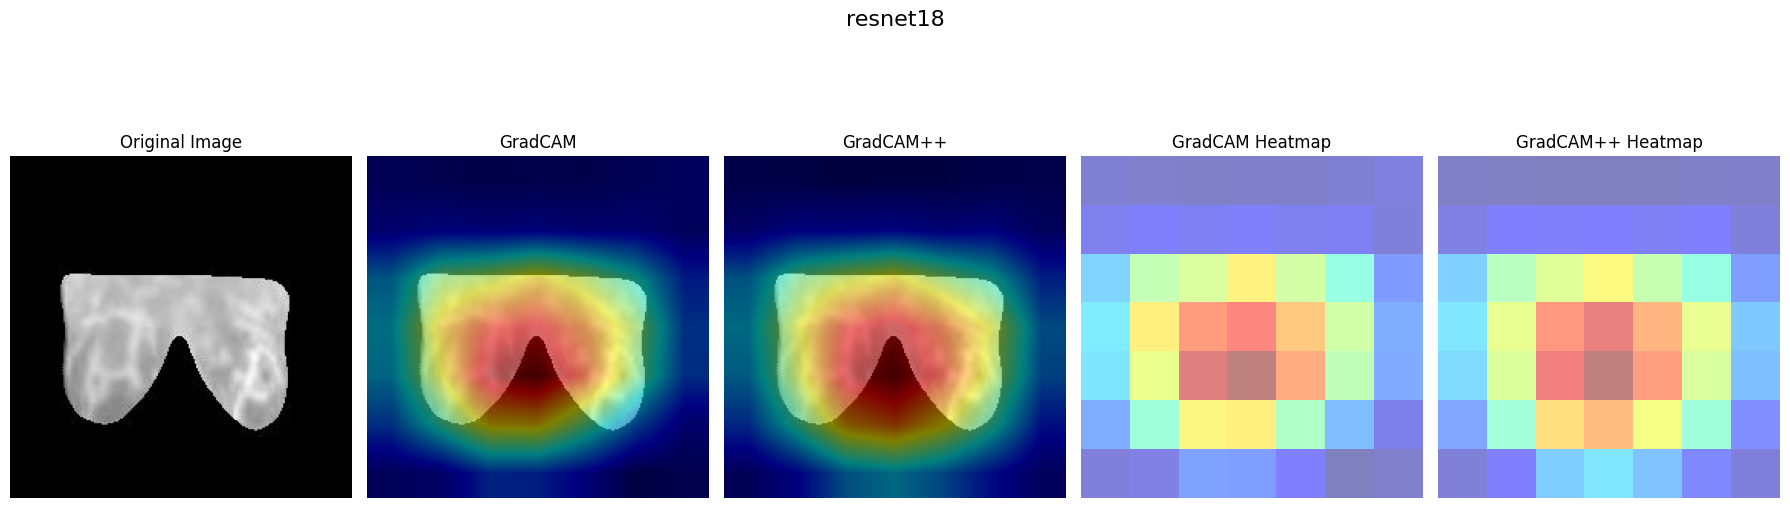

Processing image with vgg19...


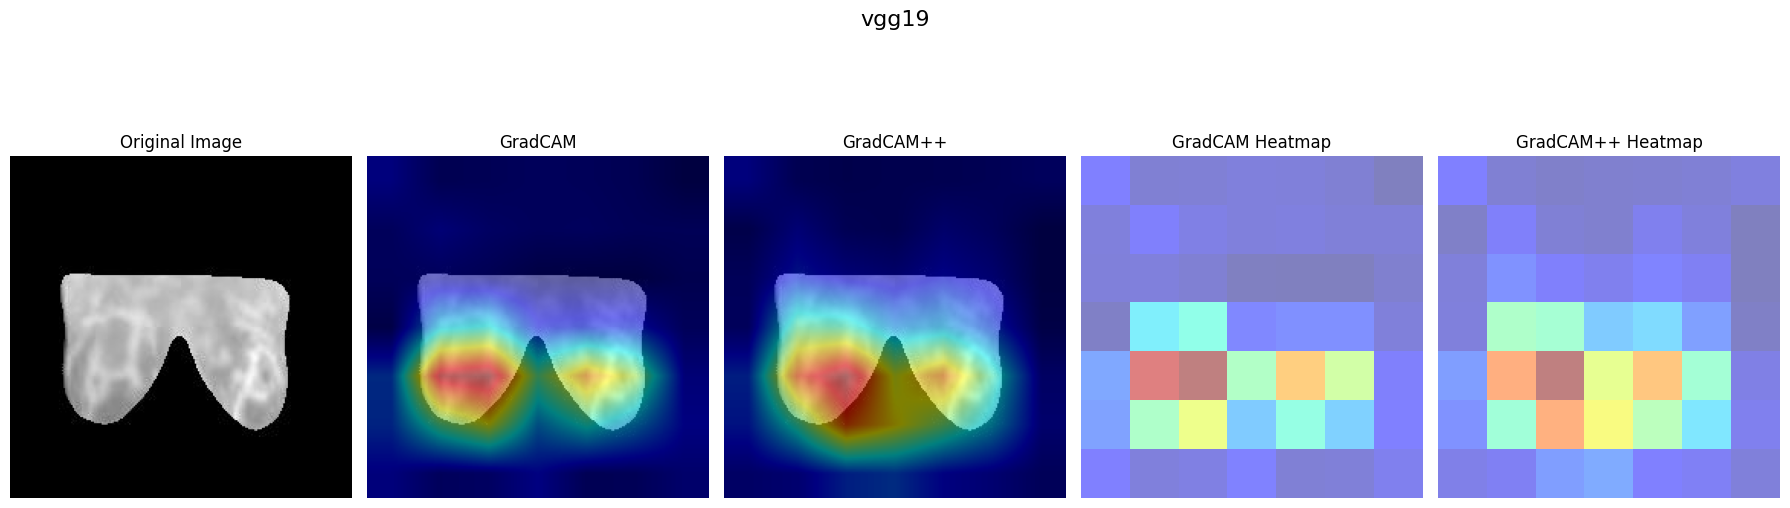

Processing image with vgg16...


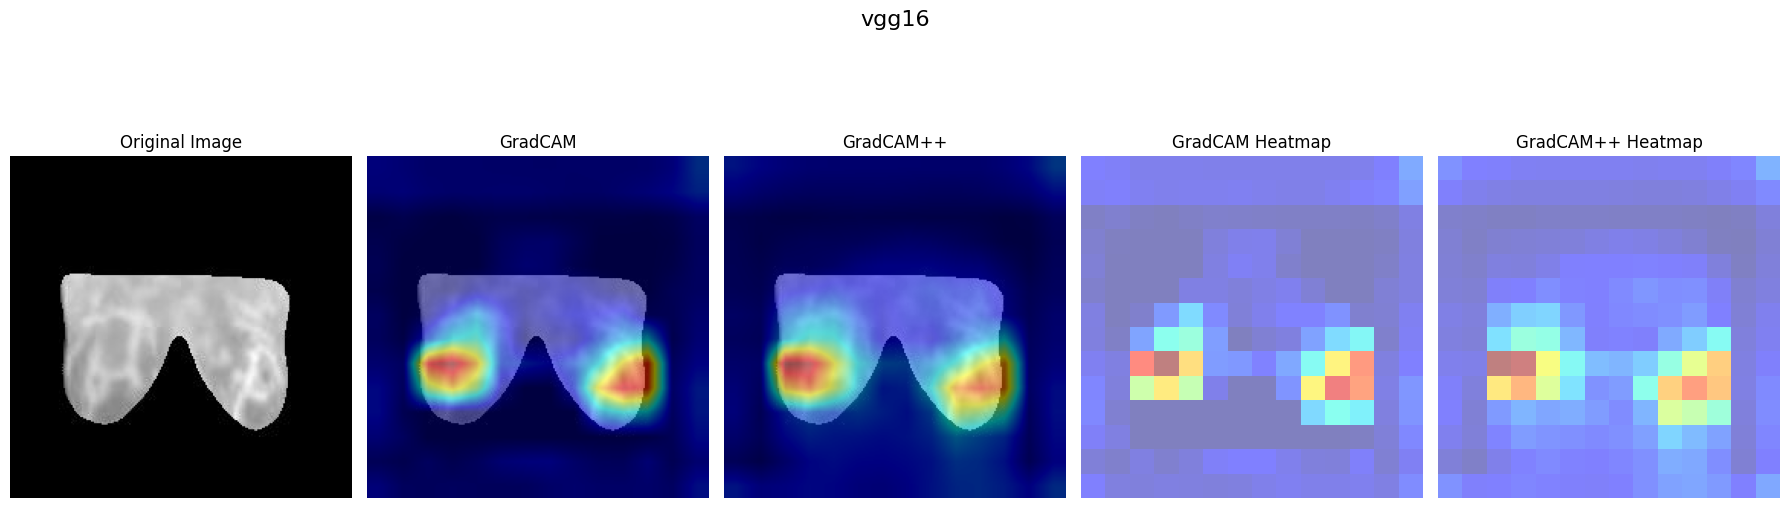

Processing image with densenet161...


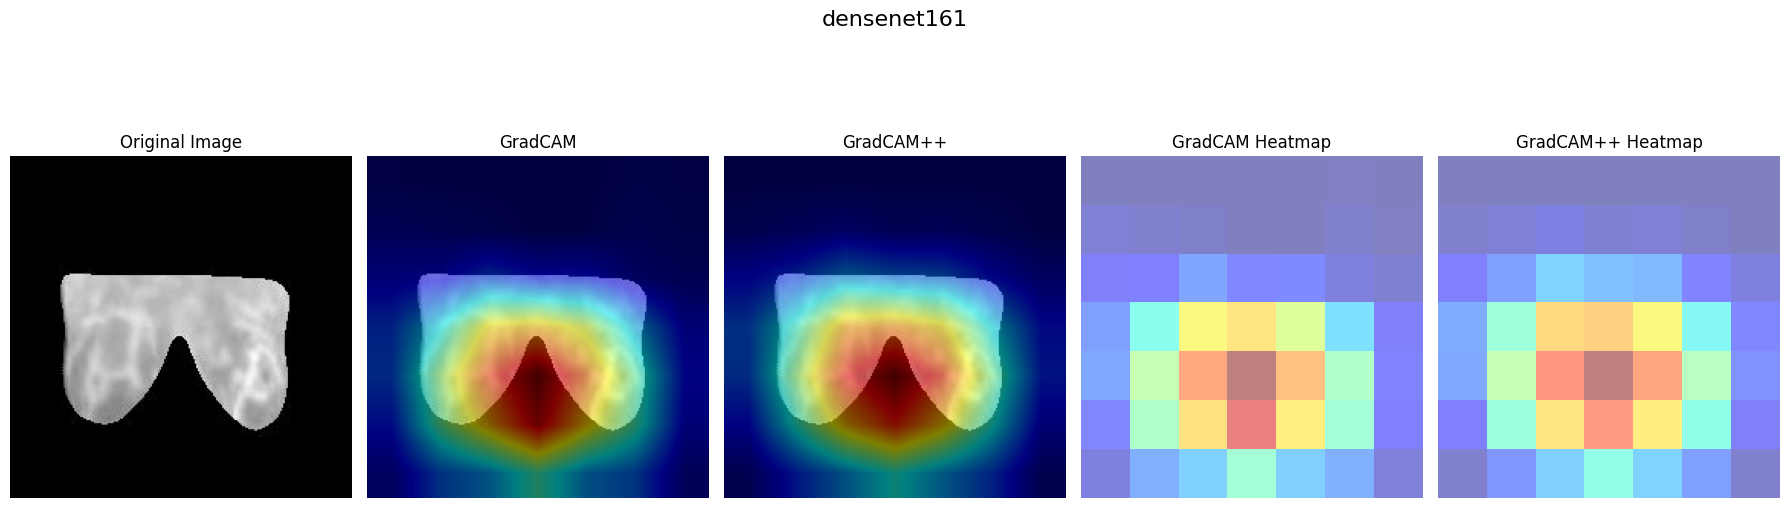

Processing image with resnext50_32x4d...


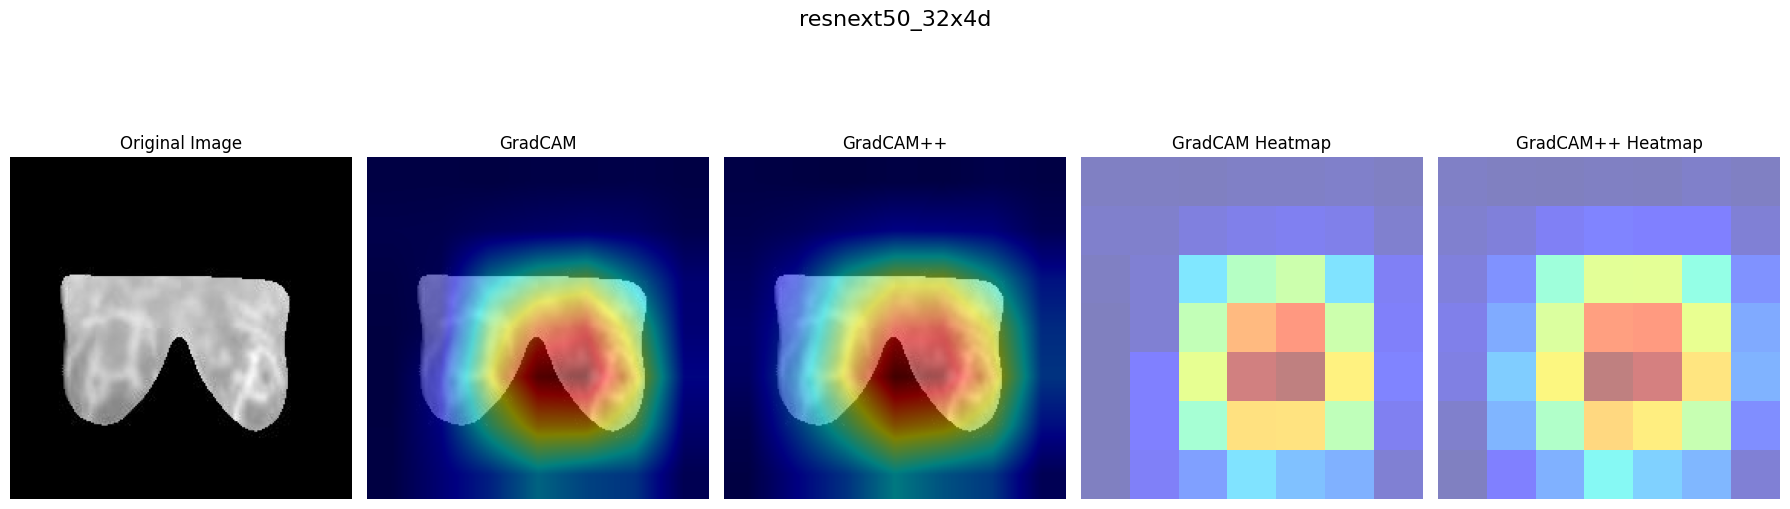

Processing image with alexnet...


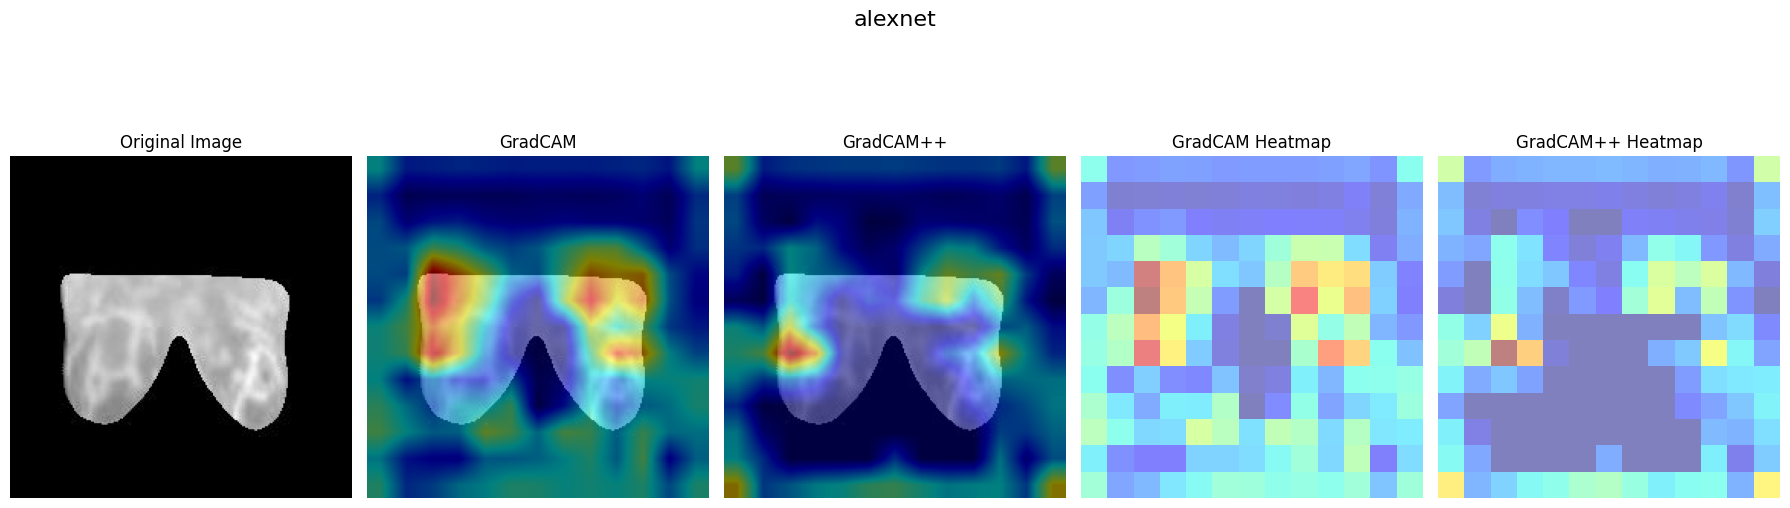

In [ ]:
image_path = "/kaggle/input/thermal-breast-cancer/abnormal_segmented_parts/seg_IR_2015-04-17_0024.jpg"
process_single_image(image_path)

Processing image with resnet18...


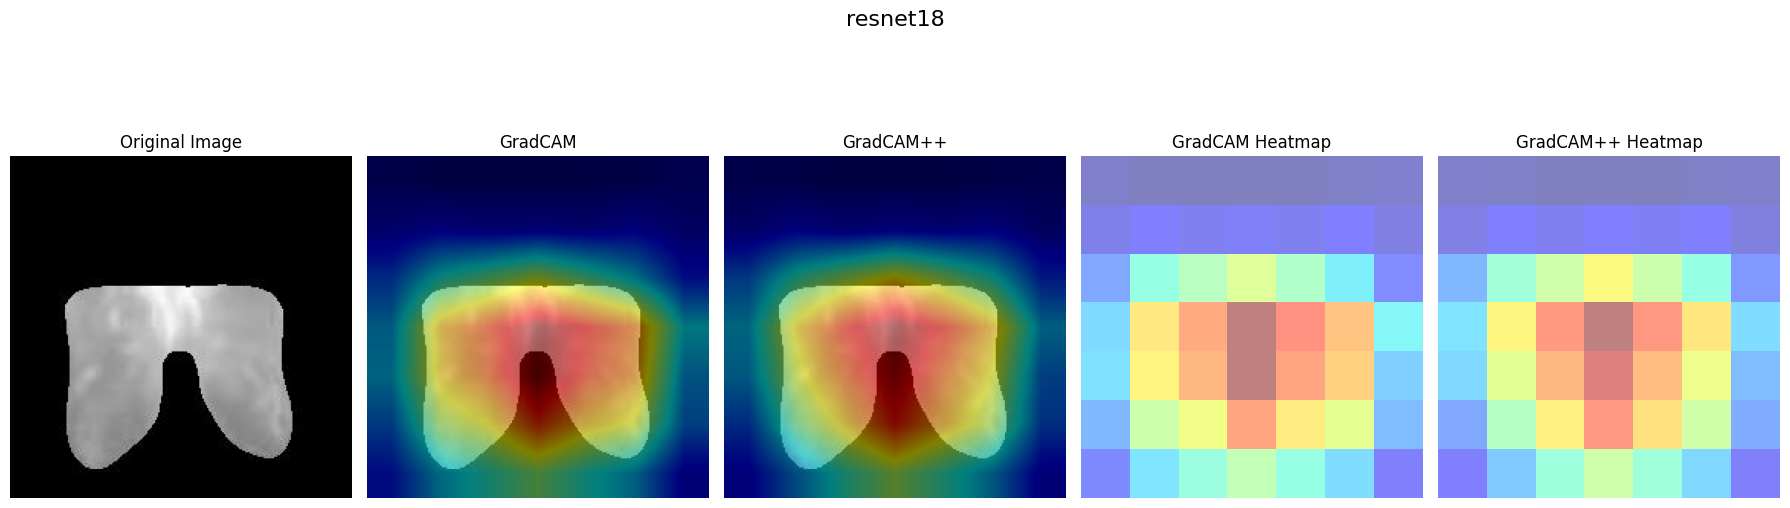

Processing image with vgg19...


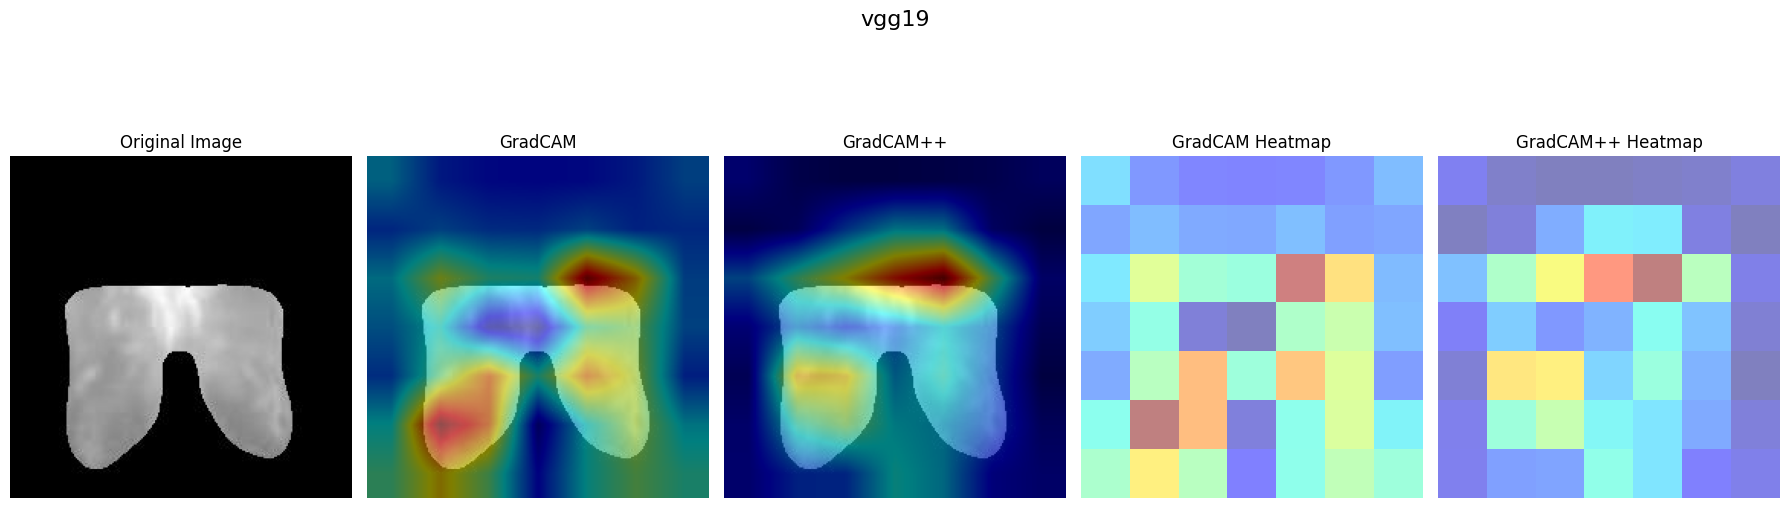

Processing image with vgg16...


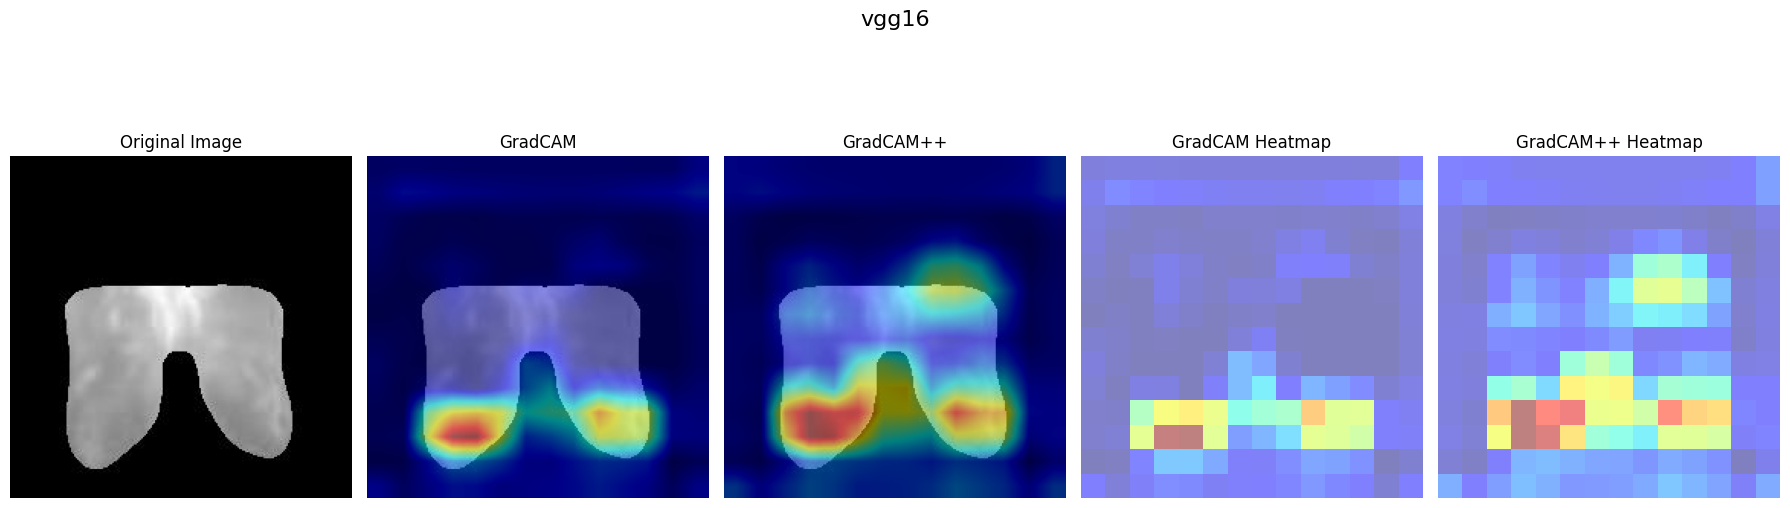

Processing image with densenet161...


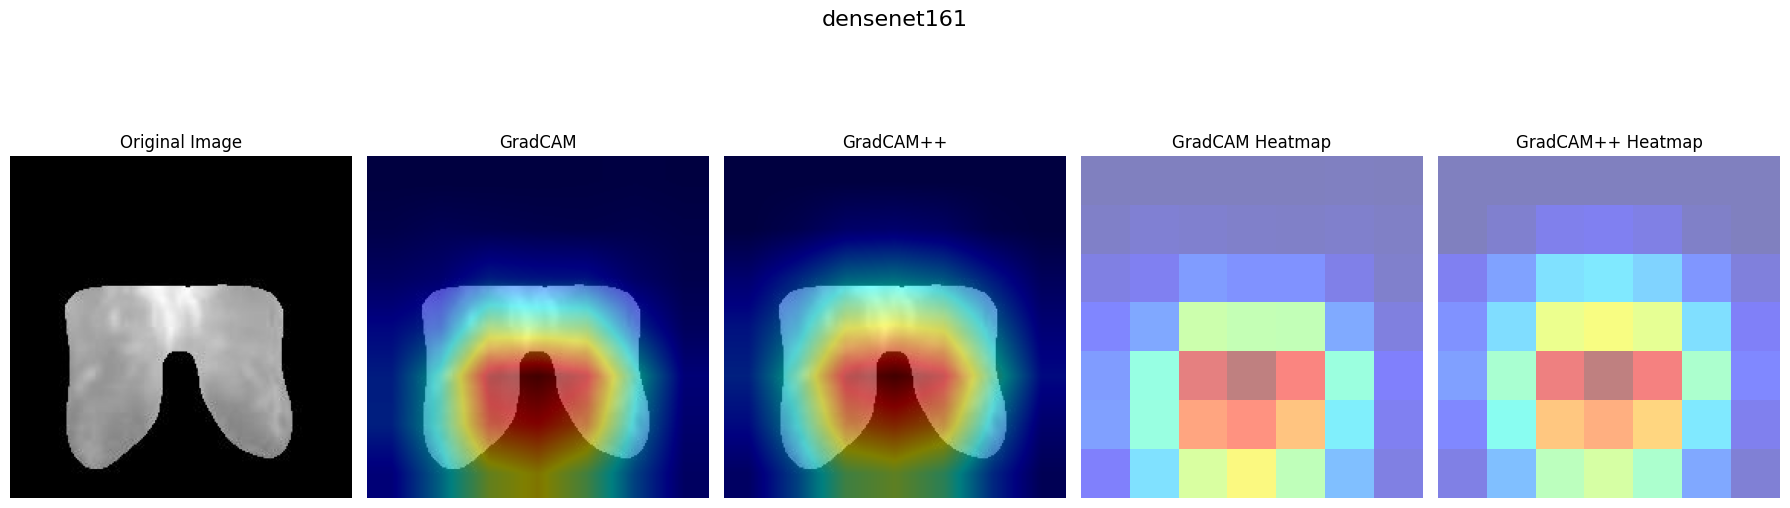

Processing image with resnext50_32x4d...


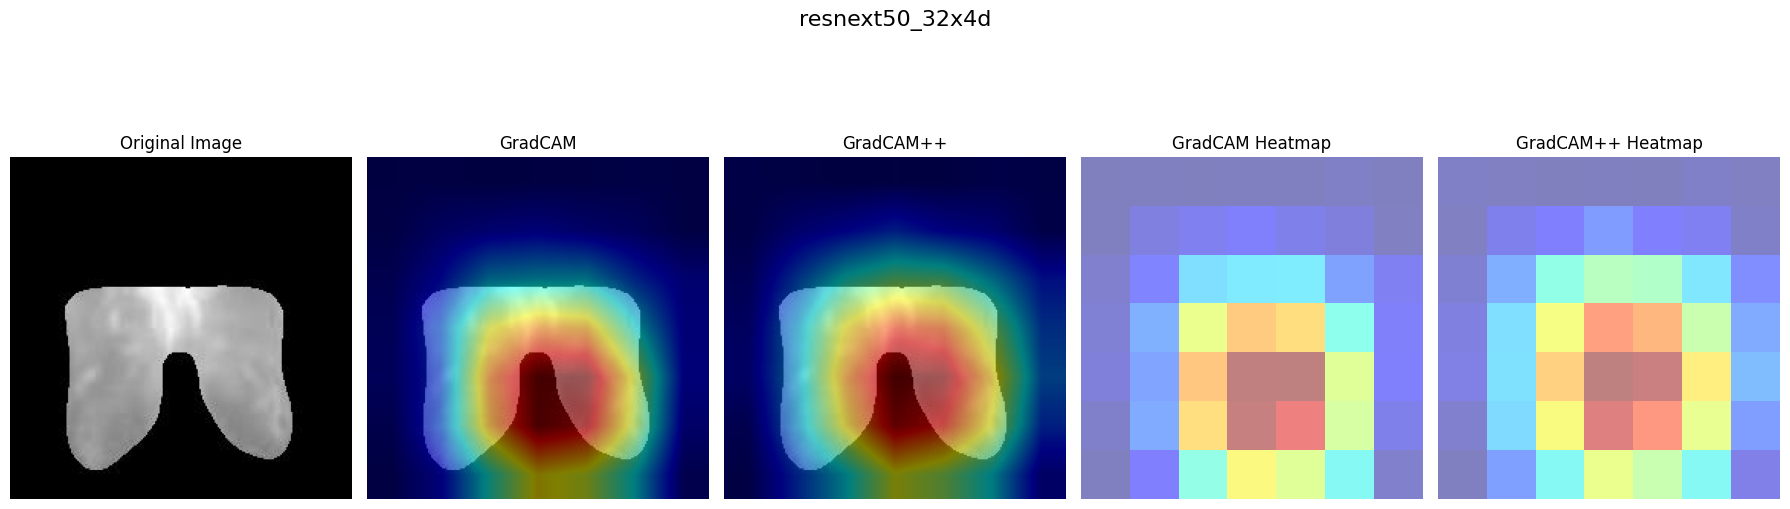

Processing image with alexnet...


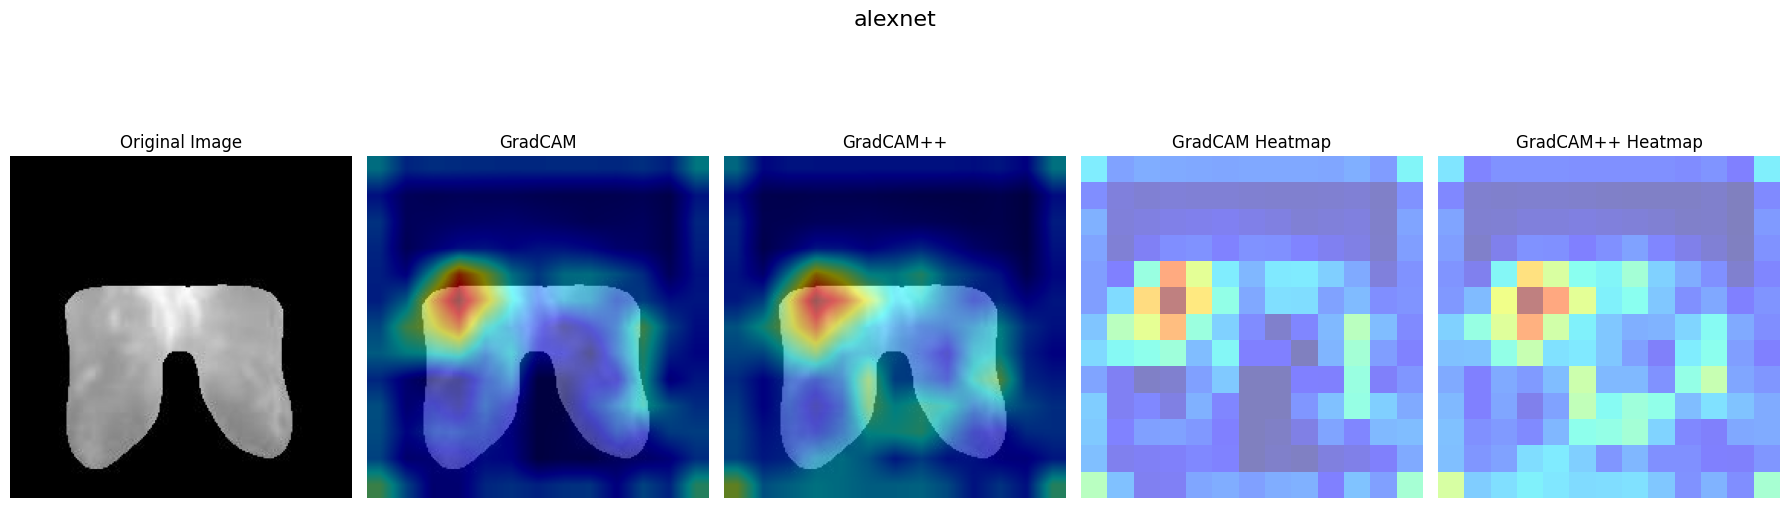

In [ ]:
image_path = "/kaggle/input/thermal-breast-cancer/normal_segmented_parts/seg_R9-17.txt.jpg"
process_single_image(image_path)

In [ ]:
print_model_architectures()


Architecture of resnet18:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (